# 2D or 3D Convolutions and Segmentation (U-Net)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from collections import OrderedDict
import torch.optim as optim

## Loading the training data

Load training data and labels

[0. 1.]


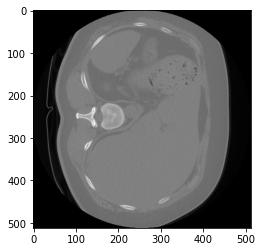

In [81]:
training_volume = nib.load("data/spleen1_img.nii.gz").get_fdata()
training_label = nib.load("data/spleen1_label.nii.gz").get_fdata()

plt.imshow(training_volume[:,:,5], cmap="gray")
print(np.unique(training_label))

In [93]:
# Visualize all slices:
def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,35])
    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[i], cmap='gray')
        ax[plt_y, plt_x].axis("off")
    plt.show()

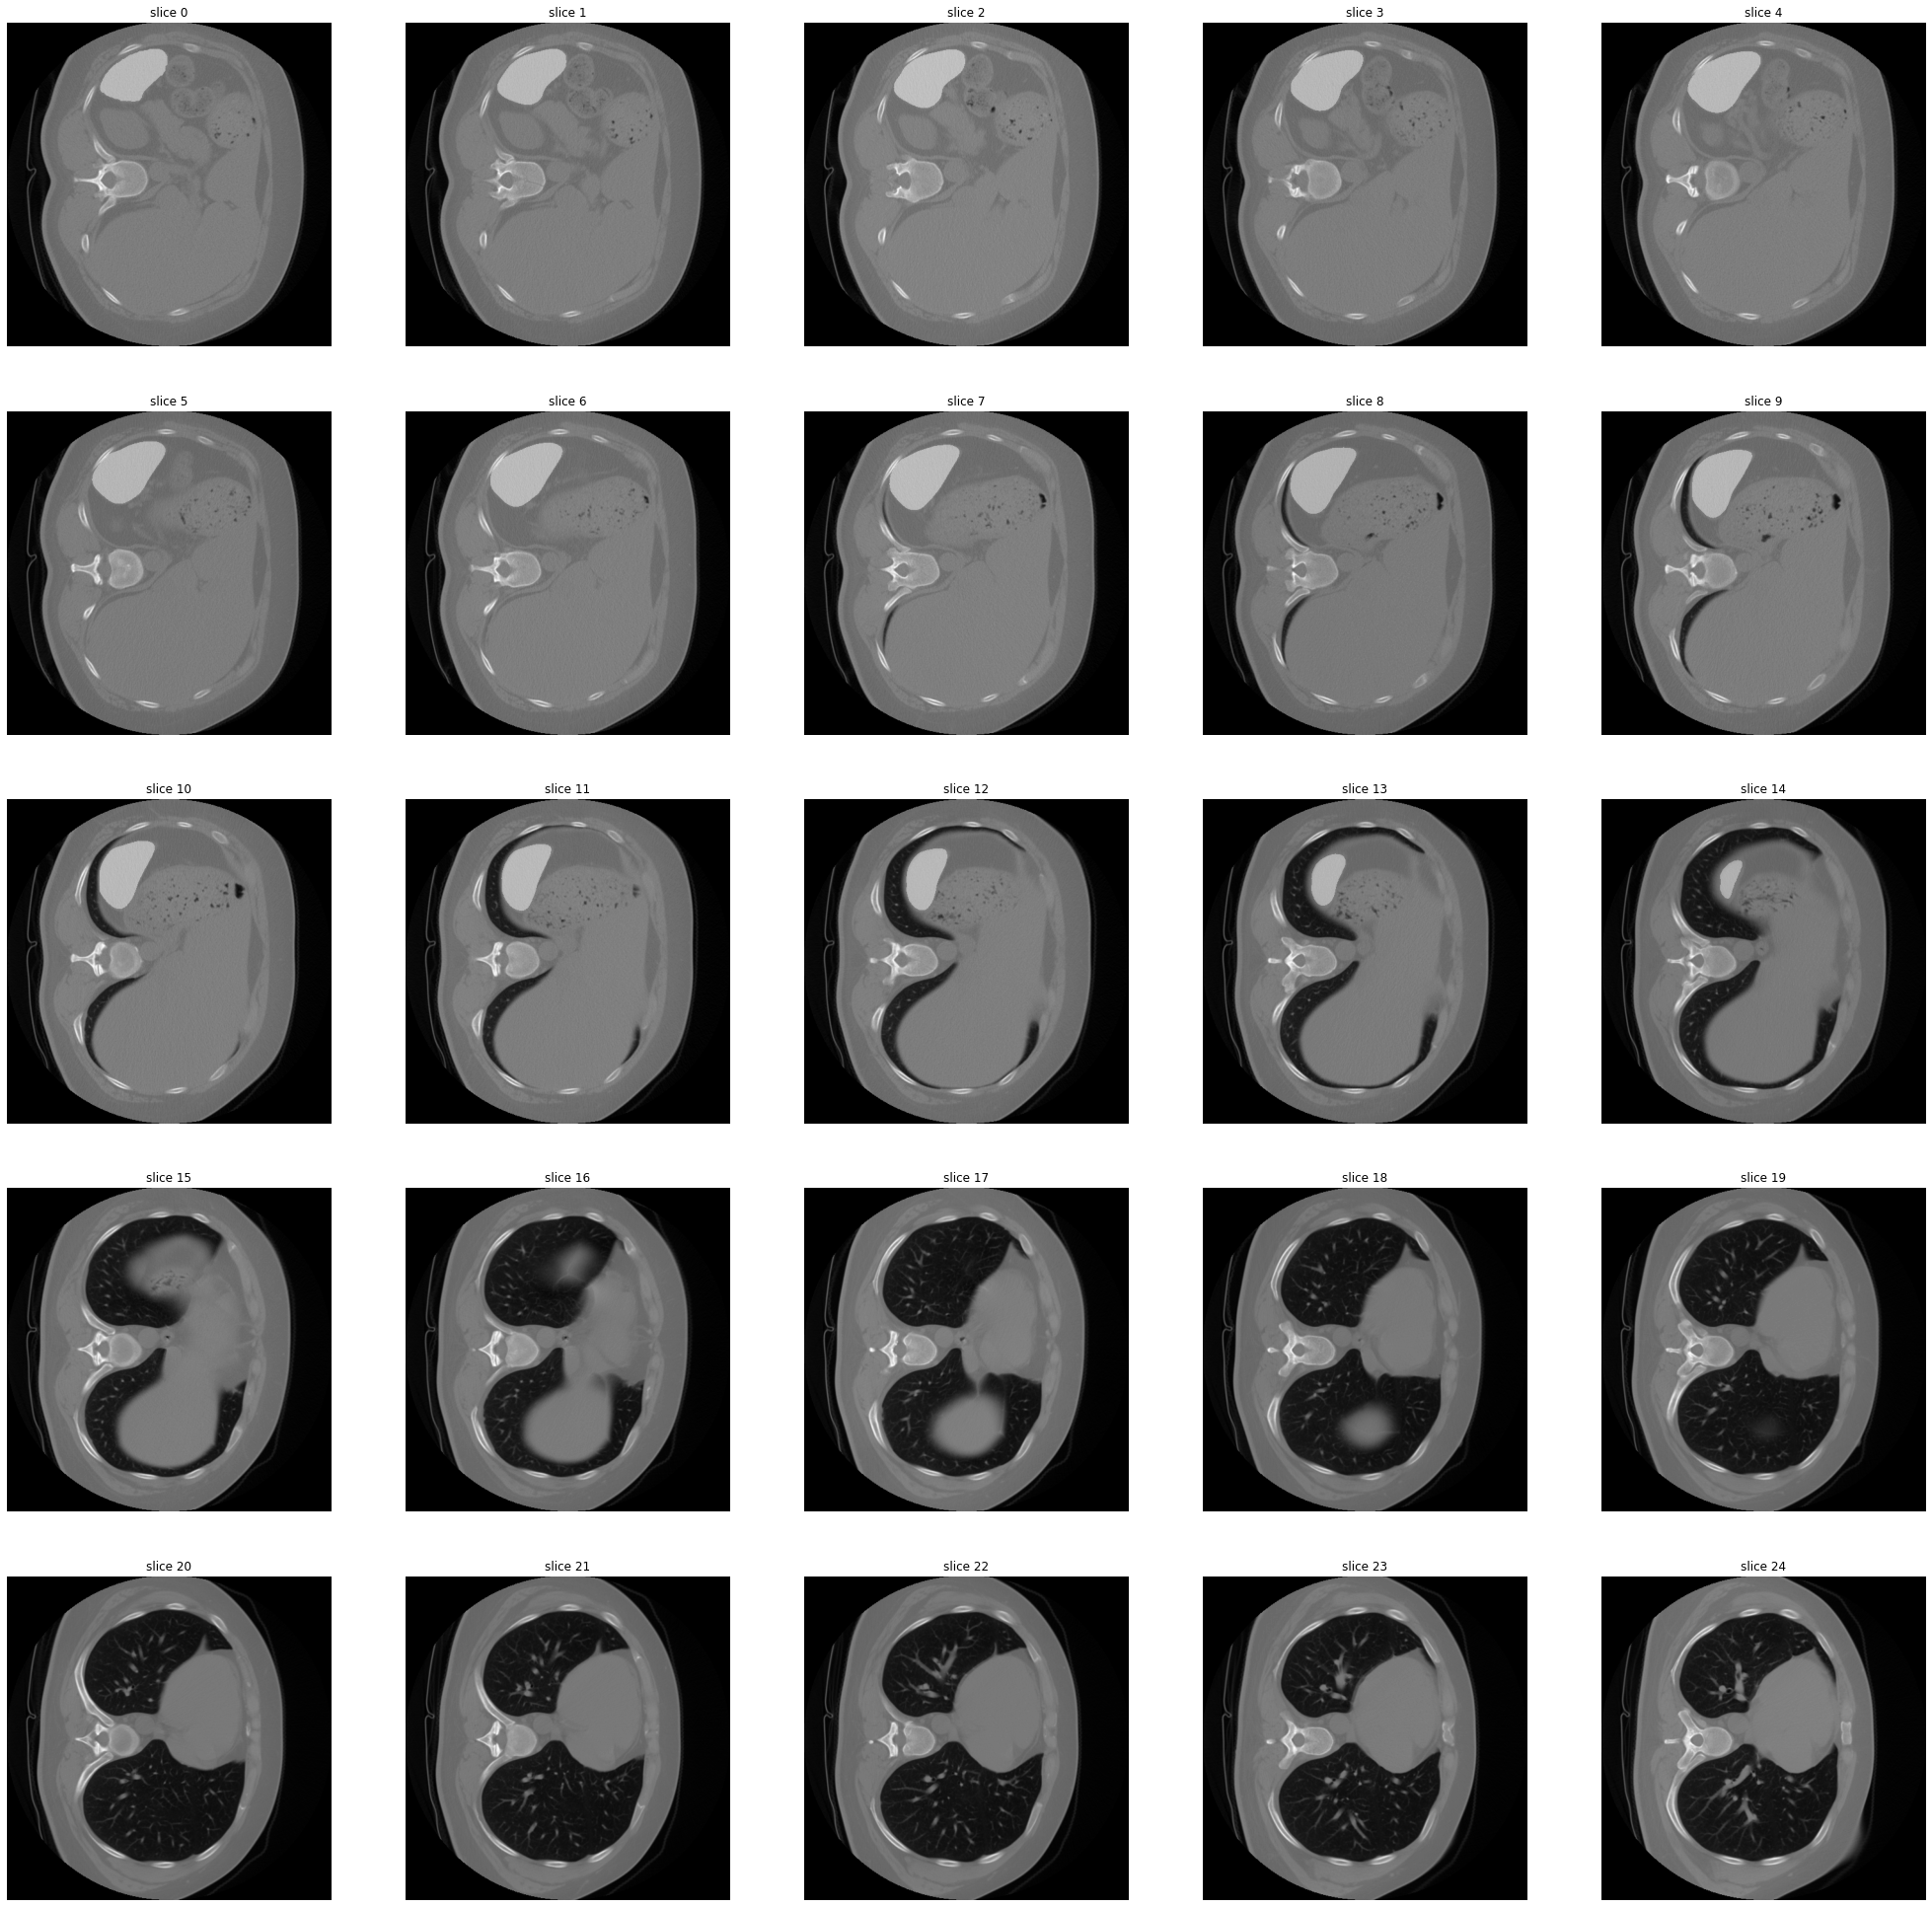

In [94]:
img = training_volume + training_label * 500
display_volume_slices(np.transpose(img, (2, 0, 1)), 5, 5)

##  2D Convolutions

In [96]:
# Define a 4x4 edge filter kernel
conv_kernel = np.ones((4,4))
conv_kernel[2:,:] = -1
print(conv_kernel)

conv2d = nn.Conv2d(1, 1, kernel_size = (4, 4), bias = False) 
conv2d

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

torch.Size([1, 1, 4, 4])


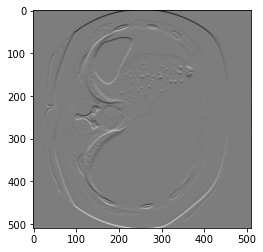

In [99]:
# Turn our convolutional kernel into a tensor to initialize convolutional layer
params = torch.from_numpy(conv_kernel).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0)
conv2d.weight = torch.nn.Parameter(params)
print(params.shape)

conv_slices = []
for ix in range(0, img.shape[2]):
    slice_tensor = torch.from_numpy((img[:,:,ix].astype(np.single)/0xff)).unsqueeze(0).unsqueeze(1)
    convolved = conv2d(slice_tensor)
    conv_slices.append(np.squeeze(convolved.detach().numpy()))

plt.imshow(conv_slices[10], cmap="gray")

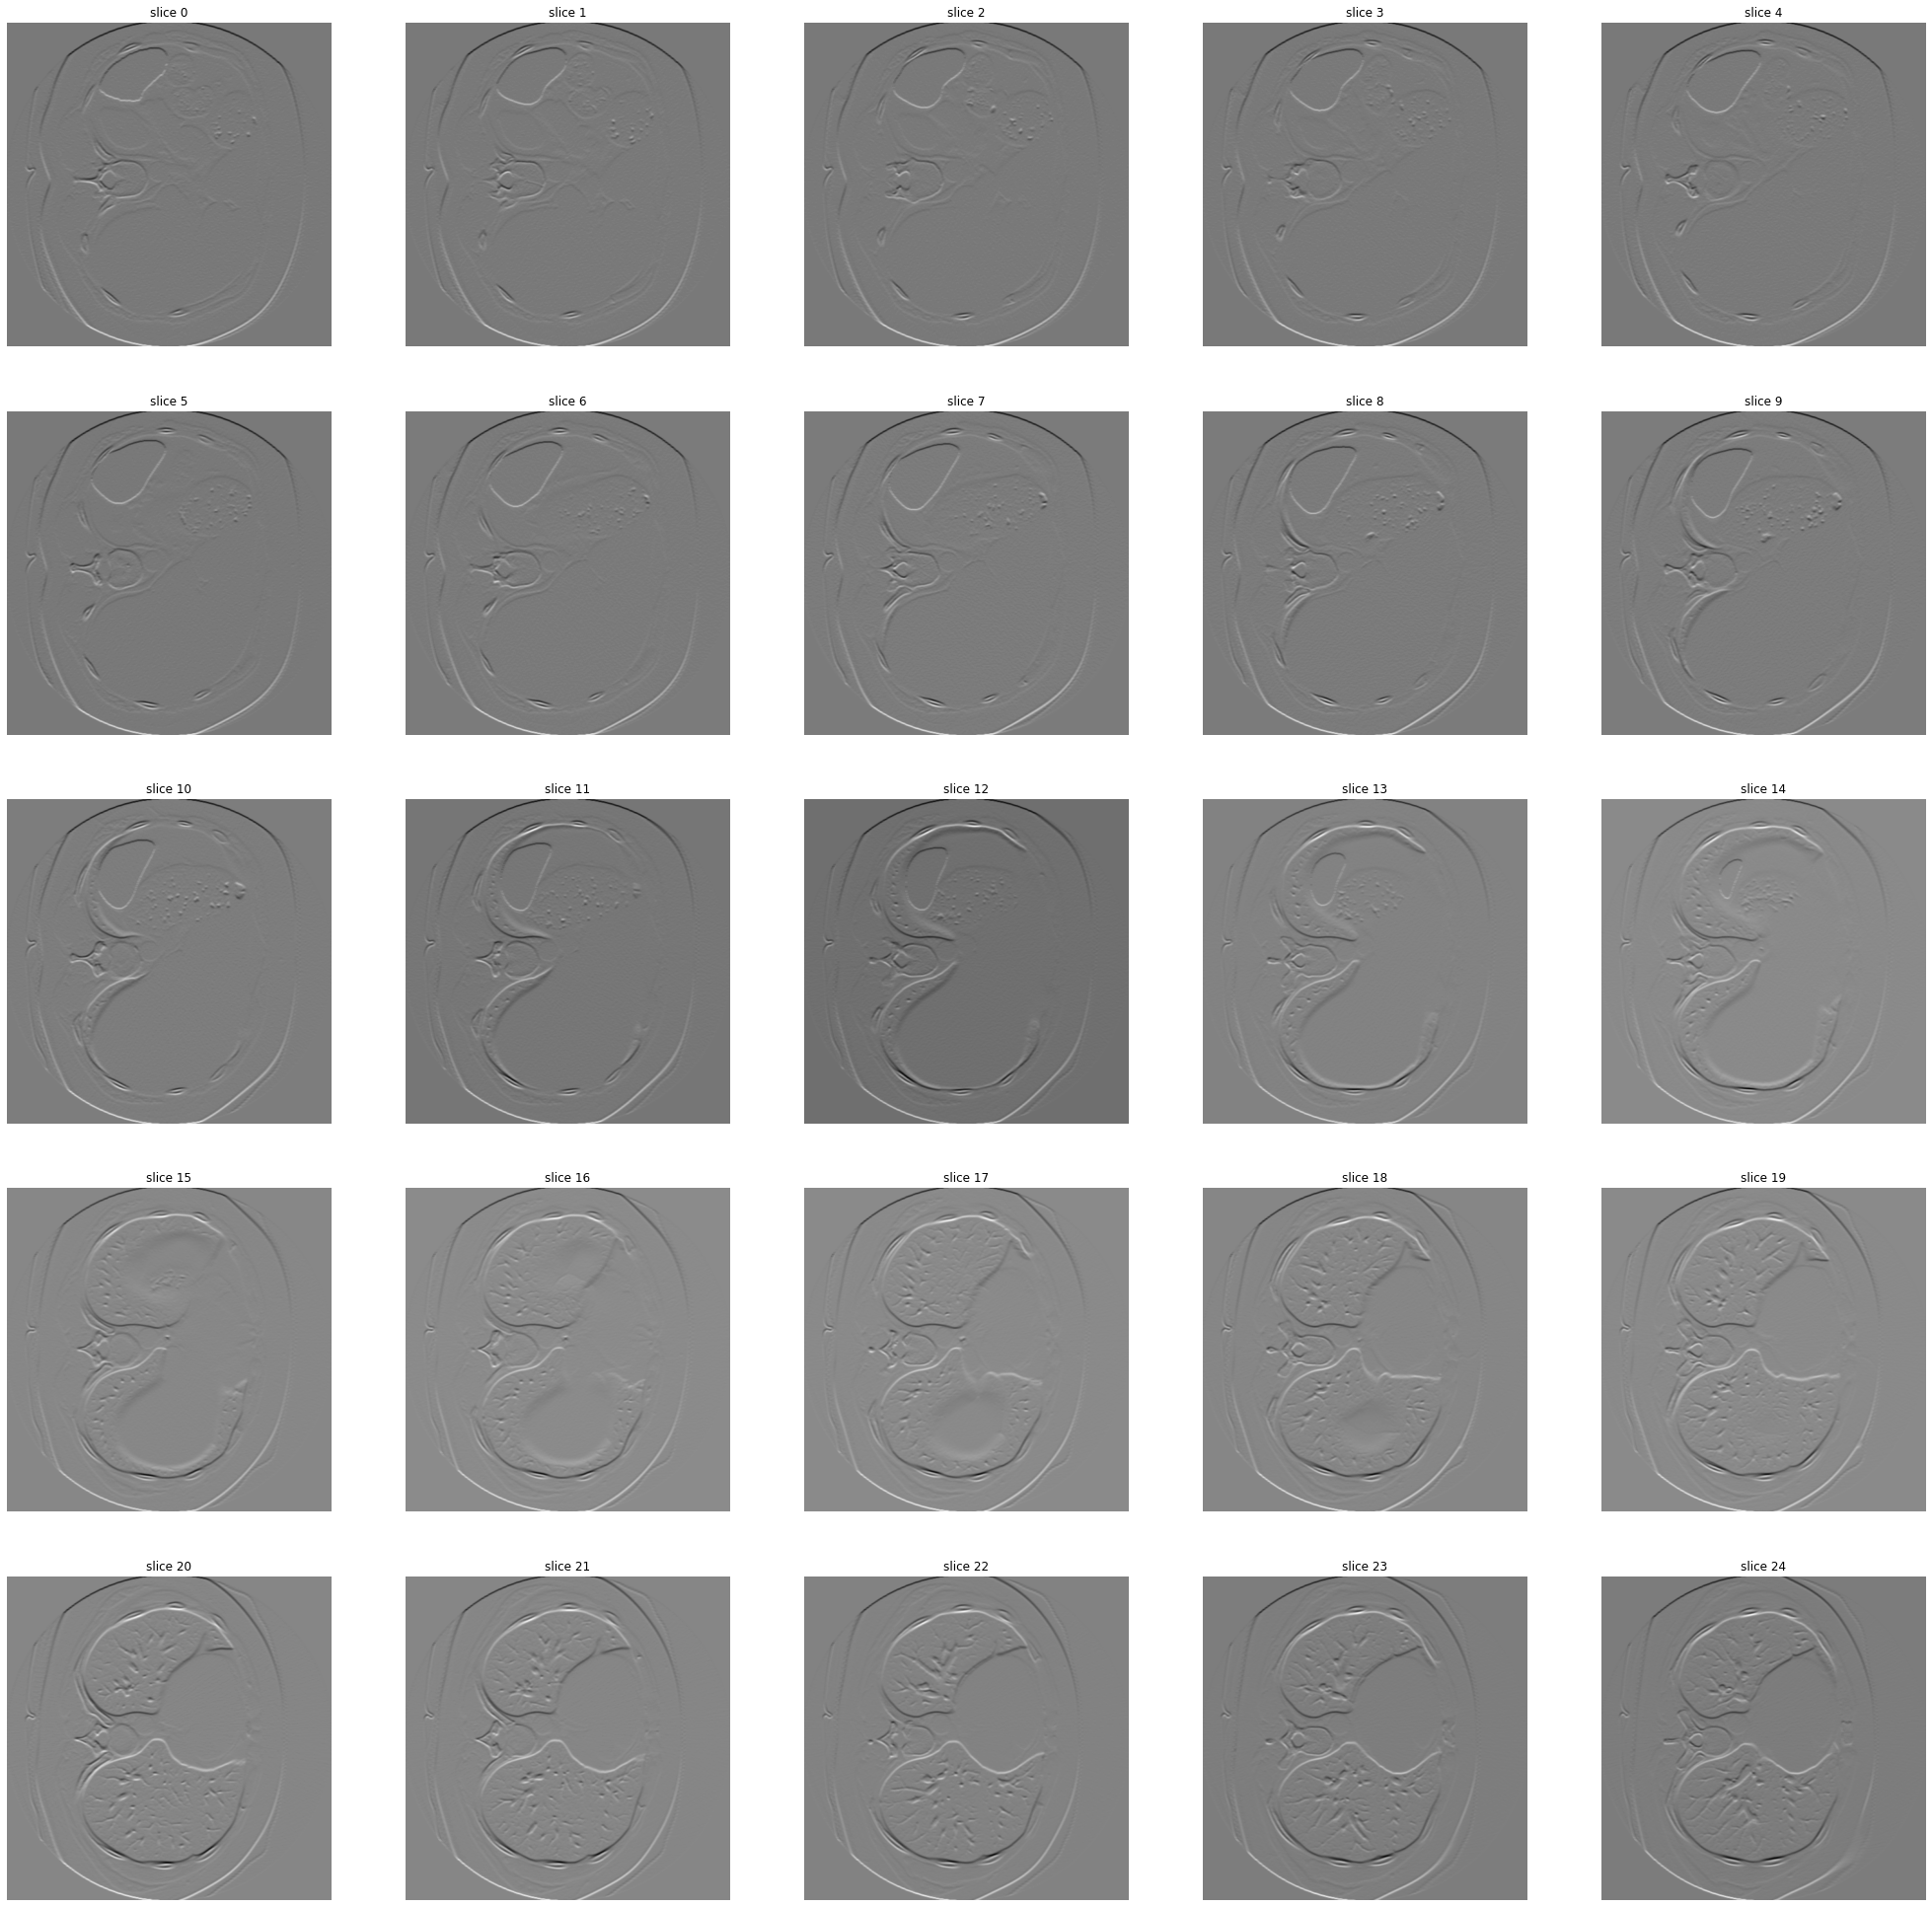

In [100]:
# Visualize the slices
display_volume_slices(conv_slices, 5, 5)

## 3D Convolutions
TASK: Using a 3D version of the same kernel, compute and time full 3D convolutions by using PyTorch's Conv3D layer. Note that our kernel represents a 2D edge filter. What would be a 3D edge filter?

In [102]:
conv3d = nn.Conv3d(1, 1, kernel_size = (4, 4, 4), bias = False) 
print(conv3d)
# Kernel
conv_kernel3d = np.array([conv_kernel, conv_kernel, -conv_kernel, -conv_kernel])
conv_kernel3d.shape, conv3d.weight.shape

Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)


((4, 4, 4), torch.Size([1, 1, 4, 4, 4]))

In [106]:
# Weights
params3d = torch.from_numpy(conv_kernel3d).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0) 
conv3d.weight = torch.nn.Parameter(params3d)
# Convert image to tensor 
conv_tensor = torch.from_numpy((img.astype(np.single)/0xff)).unsqueeze(0).unsqueeze(1)
convolved = conv3d(conv_tensor)
convolved_np = np.transpose(np.squeeze(convolved.detach().numpy()), (2, 0, 1))
conv_tensor.shape, convolved.shape,convolved_np.shape, conv_tensor.dtype

(torch.Size([1, 1, 512, 512, 65]),
 torch.Size([1, 1, 509, 509, 62]),
 (62, 509, 509),
 torch.float32)

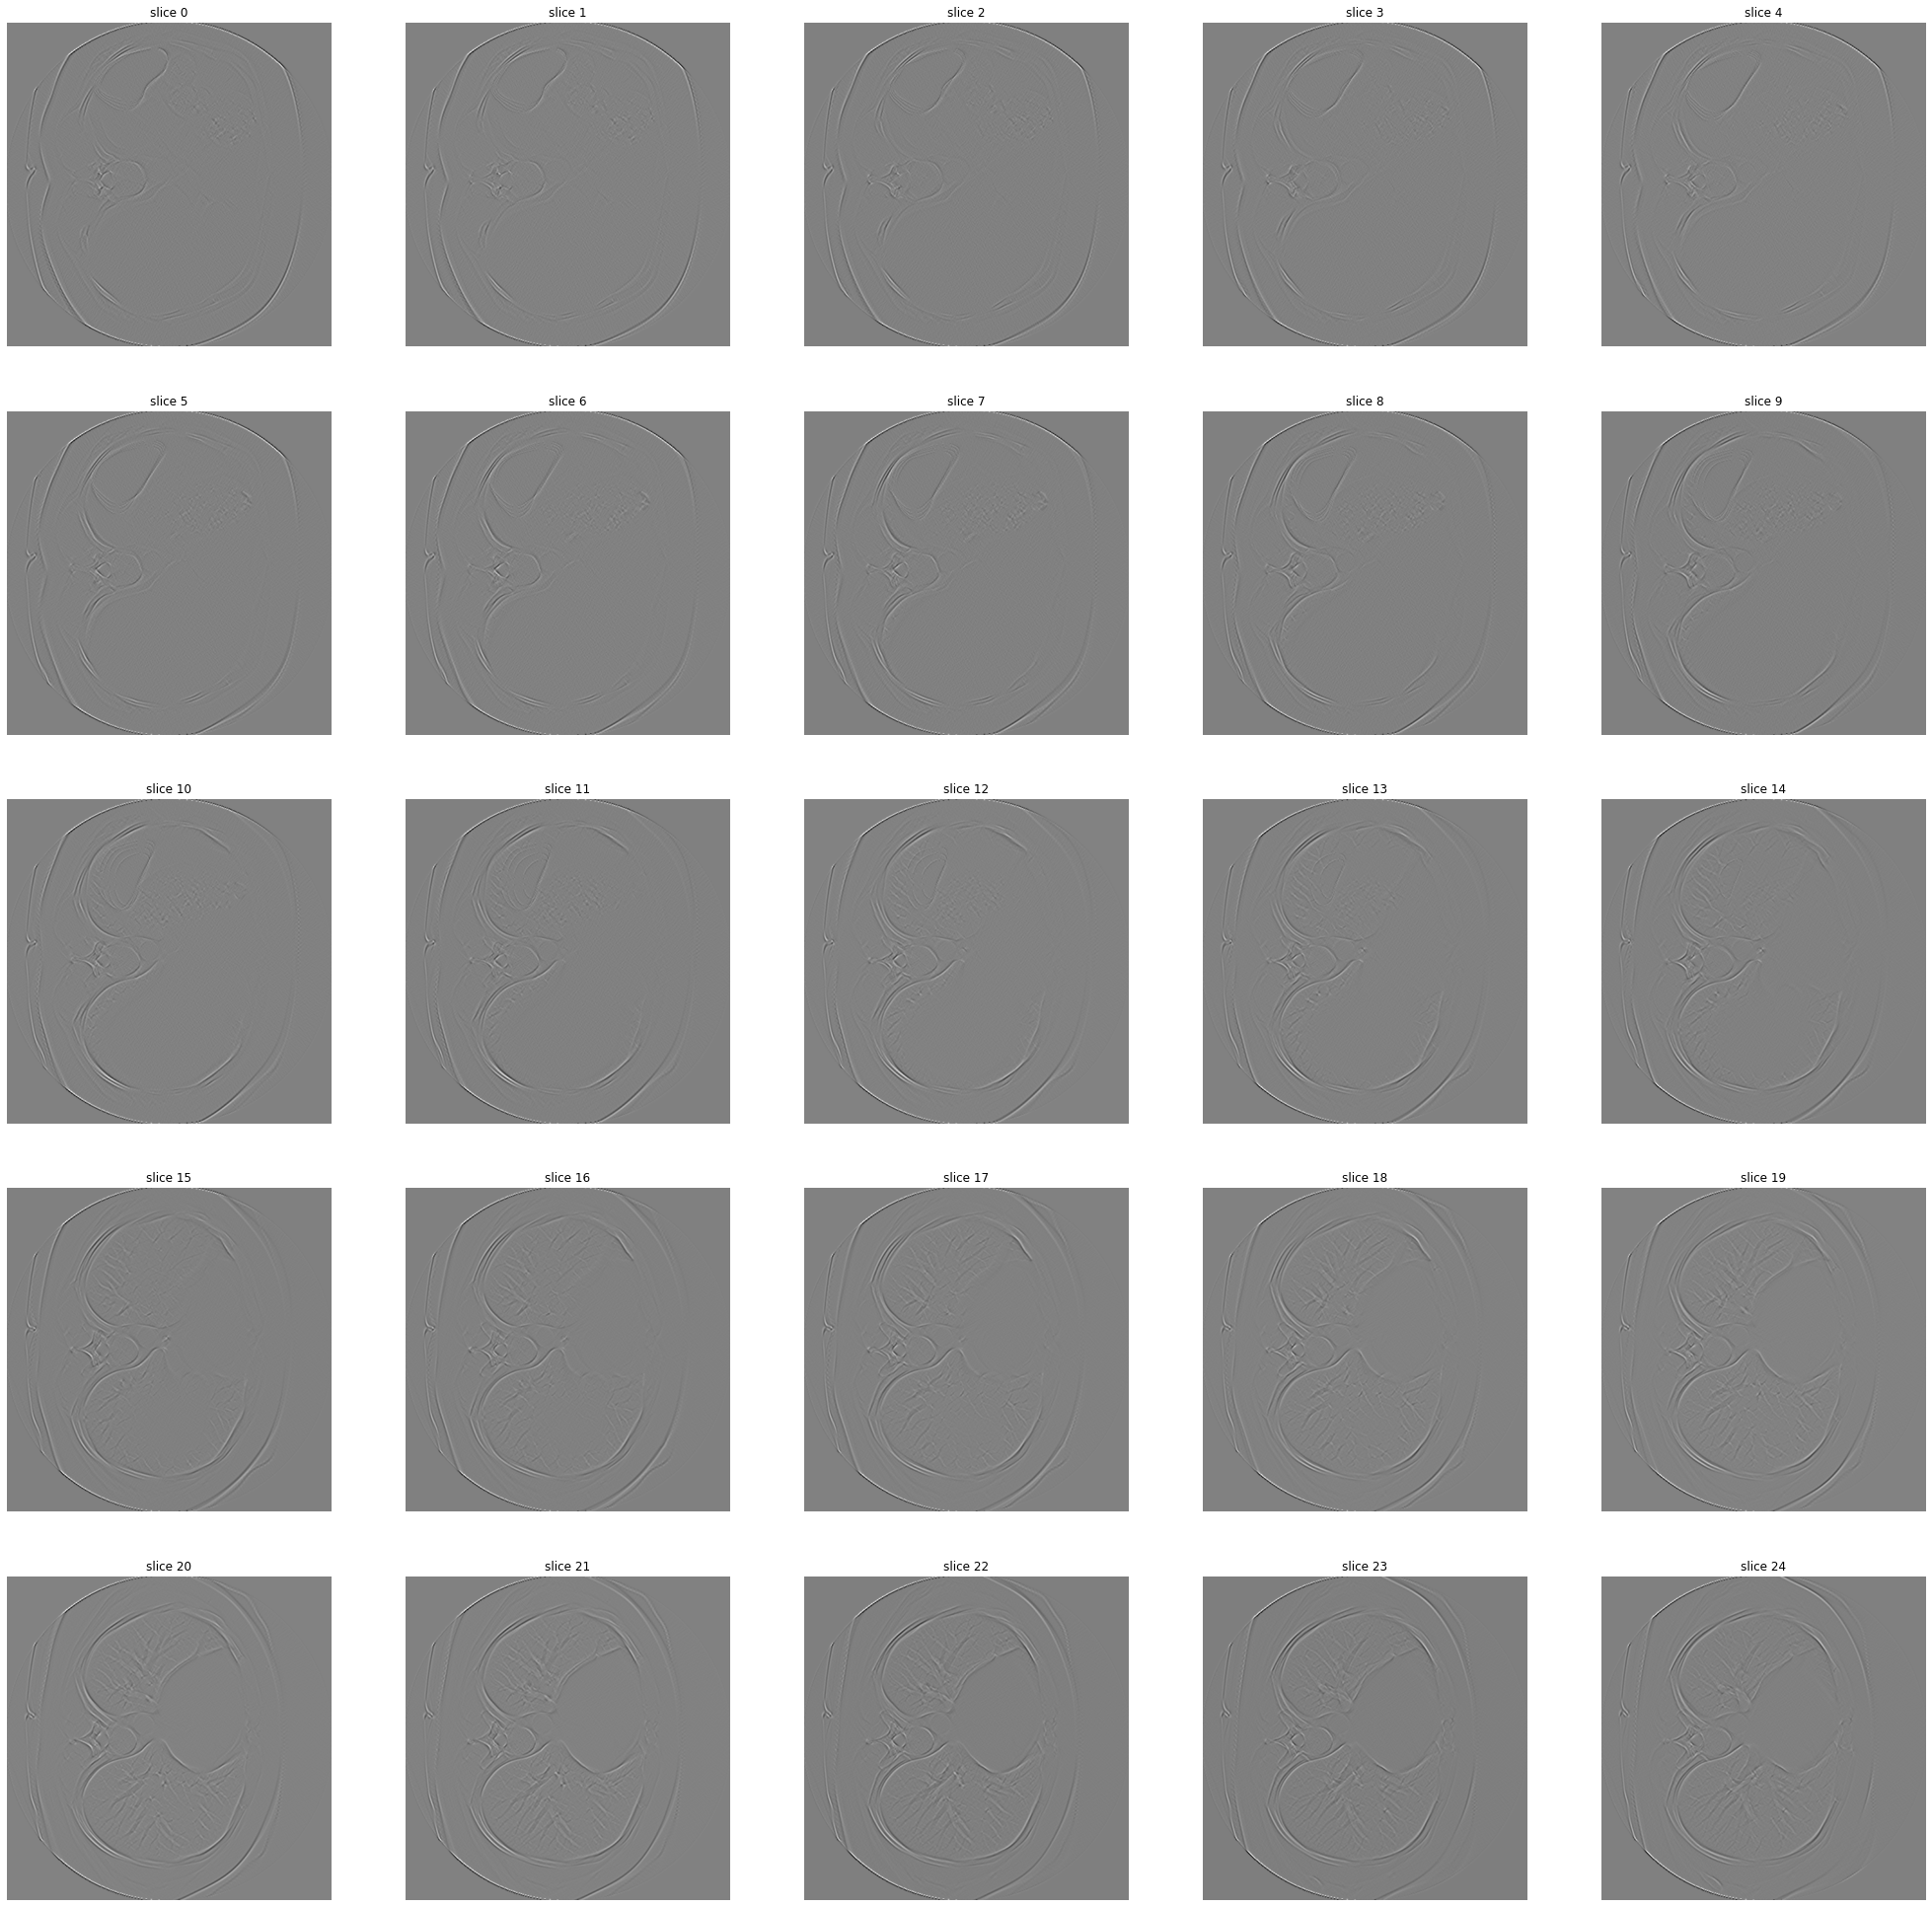

In [107]:
display_volume_slices(convolved_np, 5, 5)

## Constructing U-net
https://arxiv.org/pdf/1505.04597.pdf
<img src="hands-on.img/unet.png" width="600">

In [119]:
# refer to udacity exercise (with some modification).
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()        
        features = init_features
        self.encoder1 = self.unet_block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.unet_block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.unet_block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.unet_block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = self.unet_block(features * 8, features * 16, name="bottleneck")

        # Transposed convolutions. 
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self.unet_block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self.unet_block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(features * 2, features, name="dec1")
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)        
        self.softmax = nn.Softmax(dim = 1)
     
    # For 2D convolutions
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)        
        out_conv = self.conv(dec1)        
        return self.softmax(out_conv)

    def unet_block(self, in_channels, features, name):
        return nn.Sequential(OrderedDict([(name + "conv1", nn.Conv2d(in_channels=in_channels,
                            out_channels=features, kernel_size=3,padding=1, bias=False),),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2", nn.Conv2d(in_channels=features,out_channels=features, kernel_size=3,padding=1, bias=False),),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))]))

In [120]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")    
device

device(type='cuda')

In [131]:
# use one input channel and two output channels, Cross Entropy loss function
unet = UNet(1, 2)
unet.to(device)
 
loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
optimizer.zero_grad()
sum(p.numel() for p in unet.parameters() if p.requires_grad)

7762498

### Create training loop

In [122]:
unet.train()
for epoch in range(0,20):
    for slice_ix in range(0,15):
        slc = training_volume[:,:,slice_ix].astype(np.single)/np.max(training_volume[:,:,slice_ix])
        slc_tensor = torch.from_numpy(slc).unsqueeze(0).unsqueeze(0).to(device)   
        lbl = training_label[:,:,slice_ix]
        lbl_tensor = torch.from_numpy(lbl).unsqueeze(0).long().to(device)
        optimizer.zero_grad()        
        pred = unet(slc_tensor)
        l = loss(pred, lbl_tensor)
        l.backward()
        optimizer.step()        
    print(f"Epoch: {epoch}, training loss: {l}")        

Epoch: 0, training loss: 0.4187978506088257
Epoch: 1, training loss: 0.38152575492858887
Epoch: 2, training loss: 0.36052000522613525
Epoch: 3, training loss: 0.34715211391448975
Epoch: 4, training loss: 0.34100231528282166
Epoch: 5, training loss: 0.3344598412513733
Epoch: 6, training loss: 0.33134639263153076
Epoch: 7, training loss: 0.32808399200439453
Epoch: 8, training loss: 0.32585638761520386
Epoch: 9, training loss: 0.32408496737480164
Epoch: 10, training loss: 0.32288146018981934
Epoch: 11, training loss: 0.3215351402759552
Epoch: 12, training loss: 0.32058900594711304
Epoch: 13, training loss: 0.3194277882575989
Epoch: 14, training loss: 0.3190494775772095
Epoch: 15, training loss: 0.3195231258869171
Epoch: 16, training loss: 0.3196837902069092
Epoch: 17, training loss: 0.3181957006454468
Epoch: 18, training loss: 0.3192598223686218
Epoch: 19, training loss: 0.3170427083969116


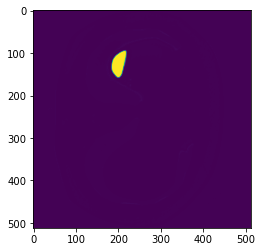

In [123]:
# Visualize our last network prediction with default colormap in matplotlib:
plt.imshow(pred.cpu().detach()[0,1])

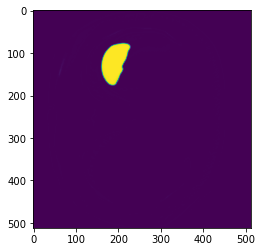

In [125]:
unet.eval()
def inference(img):
    tsr_test = torch.from_numpy(img.astype(np.single)/np.max(img)).unsqueeze(0).unsqueeze(0)
    pred = unet(tsr_test.to(device))
    return np.squeeze(pred.cpu().detach())
level = 12
img_test = training_volume[:,:,level]
pred = inference(img_test)
plt.imshow(pred[1])